<a href="https://colab.research.google.com/github/angiellanos/Prediccion_de_reservas/blob/main/Modelo_Provisiones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIVERSIDAD NACIONAL DE COLOMBIA
### Aplicaciones del aprendizaje de máquinas en actuaría y finanzas (2023-II)
#### Angie Eloisa Llanos
\\

\\



# **Modelo de Provisiones por Negligencia Médica en Aseguradoras de EEUU**

## ***Data Understanting***

Este modelo se basa en las compañías aseguradoras de accidentes de propiedad en Estados Unidos que se especializan en seguros de responsabilidad civil profesional que incluyen seguros de mala praxis médica. Los datos se obtuvieron del Anexo P - Análisis de pérdidas y gastos de pérdida, que forma parte de la base de datos de la Asociación Nacional de Comisionados de Seguros (NAIC por sus siglas en inglés). Por lo tanto, se establece que el proceso de recolección e integración de datos ya está hecho.




##### ***Descargar librerías necesarias***

In [1]:
pip install numpy scipy ripser persim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=754681 sha256=ebf1e83e028c7f1cf5a160482fa5e1b47cb861fa42300e21948ff3a68e84e585
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b049057431155934f74e20ca6001a085fcd2e615150
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=cbd40174d82dd54f8bb26f42ddb76e4476a6aaa0eb664cf375ef4d0344d85c12
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built ripser hopcroftkarp


##### ***Importar librerías necesarias***

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.distributions import triang
from ripser import ripser
from persim import plot_diagrams
pd.options.display.width = 100
pd.options.mode.chained_assignment = None

##### ***Importar bd***

In [3]:
data = pd.read_csv("https://www.casact.org/sites/default/files/2021-04/medmal_pos.csv")

#####***Descripción general del dataframe***

A continuación se detallará el nombres de variables o columnas, cantidad de datos, verificar si alguna columna es cero en todas sus entradas, y el tipo de variable, si es categórica o cuantitativa.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GRCODE              3400 non-null   int64 
 1   GRNAME              3400 non-null   object
 2   AccidentYear        3400 non-null   int64 
 3   DevelopmentYear     3400 non-null   int64 
 4   DevelopmentLag      3400 non-null   int64 
 5   IncurLoss_F2        3400 non-null   int64 
 6   CumPaidLoss_F2      3400 non-null   int64 
 7   BulkLoss_F2         3400 non-null   int64 
 8   EarnedPremDIR_F2    3400 non-null   int64 
 9   EarnedPremCeded_F2  3400 non-null   int64 
 10  EarnedPremNet_F2    3400 non-null   int64 
 11  Single              3400 non-null   int64 
 12  PostedReserve97_F2  3400 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 345.4+ KB



### *Descripción de las variables:*

De lo anterior se deduce que hay una variable no numérica, 6 cualitativas y el resto cuantitativas. A continuación se presenta la descripción brindada por la fuente de información.

**GRCODE** Código de la compañía NAIC (incluidos grupos de aseguradoras y aseguradoras individuales) \\

**GRNAME** Nombre de la compañía NAIC (incluidos los grupos de aseguradoras y las aseguradoras individuales) \\

**AccidentYear** Año del accidente(1988 to 1997) \\

**DevelopmentYear** Año de desarrollo (1988 to 1997) \\

**DevelopmentLag** Retraso en el desarrollo (AY-1987 + DY-1987 - 1) \\

**IncurLoss_F2** Pérdidas incurridas y gastos asignados reportados al final del año \\

**CumPaidLoss_F2** Pérdidas pagadas acumuladas y gastos asignados al final del año \\

**BulkLoss_F2** Reservas a granel e IBNR sobre pérdidas netas y gastos de defensa y contención de costos reportados al final del año\\

**EarnedPremDIR_F2** Primas devengadas en el año de vigencia - directas y asumidas \\

**EarnedPremCeded_F2** Primas devengadas en el año de vigencia - cedidas \\

**EarnedPremNet_F2** Primas devengadas en el año de vigencia - neta \\

**Single** 1 indica una sola entidad, 0 indica un grupo de aseguradoras \\

**PostedReserve97_F2** Reservas contabilizadas en el año 1997 tomadas de la Prueba documental de suscripción e inversión - Parte 2A, incluidas las pérdidas netas no pagadas y los gastos de ajuste de pérdidas no pagadas.

De estas 13 características, las características (AccidentYear, DevelopmentYear y DevelopmentLag) son cualitativas ordinales y (GRCODE, GRNAME y Single) son cualitativas nominales. Para estas características cualitativas, en este caso particular, no tiene sentido calcular medidas de tendencia central ni una distribución, ya sea tanto empírica como función continua. Por lo tanto, se calculan estas métricas y el resto del análisis de gráficos y modelos estadístico-matemáticos para los demás atributos, como sigue:

In [5]:
r = lambda x: round(x,2)
r(data.iloc[:, np.r_[5:11, -1:0]].describe())

,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,PostedReserve97_F2
count,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00
mean,11609.34,6706.07,1095.80,14111.61,1803.50,12308.11,57065.53
std,26802.82,17121.82,7612.67,26399.28,3893.42,24824.23,134355.53
min,-17.00,-1190.00,-32101.00,-781.00,-6214.00,-728.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,629.00
50%,645.00,187.00,0.00,1500.00,106.50,1302.00,5875.00
75%,9050.50,4385.50,107.25,18094.50,1473.50,13490.00,46762.00
max,179425.00,113189.00,104402.00,131948.00,25553.00,135318.00,702246.00



1. **Pérdidas Incurridas (IncurLoss_):** Esta variable representa las pérdidas totales que una compañía de seguros ha experimentado hasta la fecha, incluyendo las pérdidas que ya se han pagado y las que aún están pendientes de pago. Es una variable fundamental, ya que es la base para calcular las reservas futuras. Los valores negativos pueden hacer referencia a un exceso de liquidez después de pagar las reclamaciones con las reservas destinadas para ello, o que la compañía haya recibido reembolsos o recuperaciones por parte de terceros, como reaseguradores o subrogados, que superen el monto de las pérdidas pagadas o estimadas.

2. **Cumulative Paid Losses (CumPaidLoss_):** Estas son las pérdidas acumuladas que ya se han pagado a los asegurados. Es importante para evaluar el historial de pagos de pérdidas y cómo ha evolucionado con el tiempo. Los valores negativos pueden hacer referencia a un exceso de liquidez después de pagar las reclamaciones con las reservas destinadas para ello, o que la compañía haya recibido reembolsos o recuperaciones por parte de terceros, como reaseguradores o subrogados, que superen el monto de las pérdidas pagadas. Esto puede ocurrir, por ejemplo, cuando se resuelve una disputa legal a favor de la compañía o cuando se recupera parte del daño causado por un siniestro.

3. **Reservas a Granel (BulkLoss_):** Esta variable se refiere a las reservas establecidas para cubrir pérdidas futuras que se espera que surjan de eventos pasados pero que aún no se han notificado. Es esencial para estimar la cantidad de fondos que la compañía debe mantener para hacer frente a reclamaciones futuras. Los valores negativos pueden hacer referencia a una necesidad de liquidez en la reserva, la cual para esa fecha estaba ausente, o que la compañía haya sobreestimado el monto de las reservas necesarias en el pasado y haya realizado ajustes a la baja en el presente. Esto puede ocurrir, por ejemplo, cuando se resuelven reclamaciones con un costo menor al esperado o cuando se reduce la frecuencia o la severidad de los siniestros.

4. **Primas Ganadas (EarnedPremDIR_, EarnedPremCeded_, EarnedPremNet_):** Estas variables representan las primas ganadas en el año de incurrimiento, desglosadas en primas directas, cedidas y netas. Las primas ganadas son cruciales para determinar la relación entre las primas generadas y las pérdidas incurridas. Los valores negativos pueden hacer referencia a que la compañía haya devuelto parte de las primas cobradas a los asegurados, por ejemplo, por cancelación anticipada de la póliza, por reducción del riesgo asegurado o por aplicación de bonificaciones. Esto puede ocurrir, por ejemplo, cuando se produce una disminución de la siniestralidad o una mejora de las condiciones del mercado.

5. **Posted Reserves in Year 1997 (PostedReserve97_):** Estas son las reservas publicadas en el año 1997, tomadas del Anexo de Suscripción e Inversiones - Parte 2A, incluyendo pérdidas netas no pagadas y gastos no pagados de ajuste de pérdidas. Pueden proporcionar una referencia importante para la evolución de las reservas a lo largo del tiempo. Los valores negativos pueden hacer referencia a que la compañía haya realizado revisiones a la baja de sus estimaciones de reservas, debido a una mejor información sobre la frecuencia y la severidad de los siniestros, o a cambios en las normas contables o regulatorias. Esto puede ocurrir, por ejemplo, cuando se cierran reclamaciones con un costo menor al previsto o cuando se aplican criterios más estrictos para reconocer las reservas.




**Entidad Individual o Grupo (Single)**: Esta variable indica si se trata de una entidad individual (1) o una aseguradora de grupo (0). Esta distinción puede ser relevante para comprender las diferencias en la gestión de reservas entre compañías individuales y grupos de aseguradoras. Por lo tanto, se realizará un análisis general sin tomar en cuenta esta variable; y además, un análisis discriminado por esta variable, con el fin de identificar y describir adecuadamente la información y si estos valores cambian mucho para cada variable.

A continuación realizaremos análisis a cada variable sin discriminar por aseguradoras.

**Histogramas:**


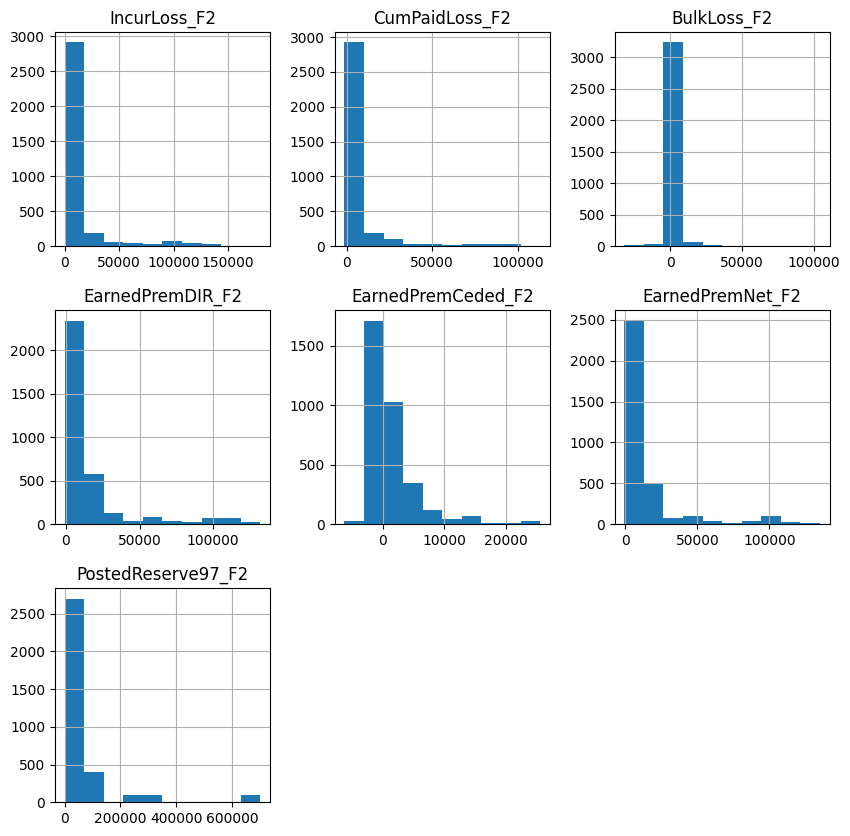

In [6]:
data.hist(column=["IncurLoss_F2","CumPaidLoss_F2","BulkLoss_F2","EarnedPremDIR_F2","EarnedPremCeded_F2","EarnedPremNet_F2","PostedReserve97_F2"], figsize=(10,10))
plt.show()

Con el uso del histograma y de las medidas de tendencia central, se logra identificar que las variables IncurLoss_F2, CumPaidLoss_F2, tienen sesgo a la derecha con cola pesada porque sus mediana son 645 y 187 respectivamente mientras que su máximo valor está en 179,425.0 y 113,189.0 respectivamente. Mientras que BulkLoss_F2 presenta un sesgo a los dos lados siendo más pesada a la derecha porque su mediana es 0, es decir, presenta mayor rango de variabilidad a la derecha. Para las variables EarnedPremDIR_F2, EarnedPremNet_F2, PostedReserve97_F2, todas presentan un sesgo a la derecha, cuyas medianas están dadas por 1,500.0, 1,302.0 y	5,875.0 respectivamente mientras que sus valores máximos están dados por 131,948.0, 25,553.0,	135,318.0 y 702,246.0. Finalmente la variable EarnedPremCeded_F2 presenta sesgo a la derecha, pero muchos valores negativos cercanos a cero o con muy poco sesgo a la izquierda.


En la variable IncurLoss_F2, no es normal que tenga valores tan altos y tan dispersos. Esto puede indicar que la compañía ha tenido muchos siniestros graves o costosos, o que ha subestimado el riesgo de sus pólizas. También puede indicar que la compañía ha tenido dificultades para recuperar parte de las pérdidas por parte de terceros, como reaseguradores o subrogados. Siendo así, las compañías deberían revisar su política de tarificación y suscripción, así como su gestión de reservas, para evitar tener pérdidas tan elevadas en el futuro.


En la variable CumPaidLoss_F2, no es normal que tenga valores negativos. Esto puede indicar que la compañía ha recibido más reembolsos o recuperaciones por parte de terceros, como reaseguradores o subrogados, que el monto de las pérdidas pagadas. Esto puede ocurrir, por ejemplo, cuando se resuelve una disputa legal a favor de la compañía o cuando se recupera parte del daño causado por un siniestro. La compañía debería revisar su política de reclamaciones y ajuste de pérdidas, así como su relación con los terceros involucrados, para evitar tener valores negativos en esta variable.

Para la variable BulkLoss_F2, no es normal que tenga valores negativos. Esto puede indicar que la compañía ha sobreestimado el monto de las reservas necesarias en el pasado y ha realizado ajustes a la baja en el presente. Esto puede ocurrir, por ejemplo, cuando se resuelven reclamaciones con un costo menor al esperado o cuando se reduce la frecuencia o la severidad de los siniestros. Aquí, la compañía debería revisar su política de estimación y reconocimiento de reservas, así como su metodología y criterios para hacerlo, para evitar tener valores negativos en esta variable.

Para las variables EarnedPremDIR_F2, EarnedPremNet_F2 y PostedReserve97_F2, no es normal que tengan valores tan altos y tan dispersos. Esto puede indicar que la compañía ha cobrado primas muy elevadas a sus asegurados, o que ha establecido reservas muy conservadoras para hacer frente a las reclamaciones futuras. Esto puede ocurrir, por ejemplo, cuando la compañía tiene una posición dominante en el mercado o cuando tiene una aversión al riesgo muy alta. Aquí, que la compañía debería revisar su política de tarificación y suscripción, así como su política de estimación y reconocimiento de reservas, para evitar tener valores tan elevados en estas variables.

Para la variable EarnedPremCeded_F2, no es normal que tenga valores negativos, ya que representa las primas cedidas a los reaseguradores. Esto puede indicar que la compañía ha recibido más primas de los reaseguradores que las que les ha pagado. Esto puede ocurrir, por ejemplo, cuando la compañía cancela parte de sus contratos de reaseguro o cuando recibe bonificaciones por su buen desempeño.

Estos valores de las métricas de tendencia central, así como la forma y la desviación de la distribución, podrían variar y mejorar si se analizan por separado las aseguradoras individuales y las de grupo. Esto se debe a que parece que las aseguradoras de grupo son las que están sesgando tanto estas variables.


**Diagrama de correlación:**

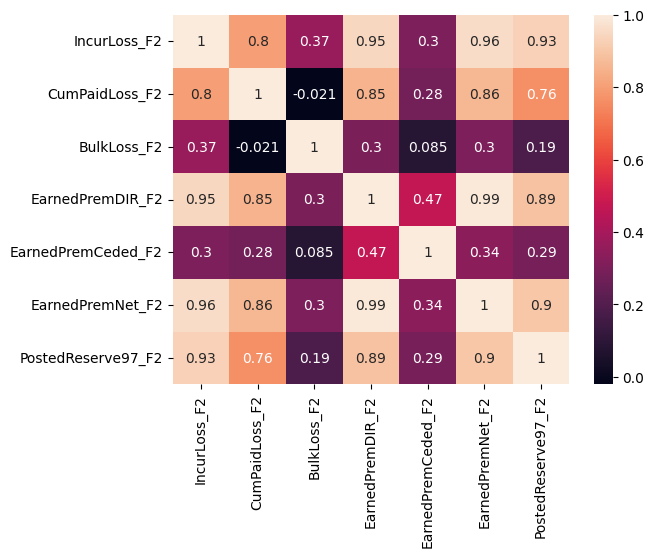

In [7]:
data_heatmap = data[["IncurLoss_F2","CumPaidLoss_F2","BulkLoss_F2","EarnedPremDIR_F2","EarnedPremCeded_F2","EarnedPremNet_F2","PostedReserve97_F2"]]

# Calcular la matriz de correlaciones
data_corr = data_heatmap.corr()

# Crear el diagrama de calor con Seaborn
sns.heatmap(data_corr, annot=True)
plt.show()

Por lo cual se puede deducir que las variables que tienen correlación directa son:
* IncurLoss_F2 con CumPaidLoss_F2, EarnedPremDIR_F2, EarnedPremNet_F2 y PostedReserve97_F2.
* CumPaidLoss_F2 con EarnedPremDIR_F2, EarnedPremNet_F2 y PostedReserve97_F2.
* EarnedPremDIR_F2 con EarnedPremNet_F2 y PostedReserve97_F2.
* EarnedPremNet_F2 con PostedReserve97_F2.

Recordando así que la correlación es una relación simétrica.

Note que BulkLoss_F2 y EarnedPremCeded_F2 presentan niveles de correlación cercanos a cero, esto implica que no tienen ningún comportamiento lineal respecto del resto de variables. Viendo estas correlaciones gráficamente se tiene:

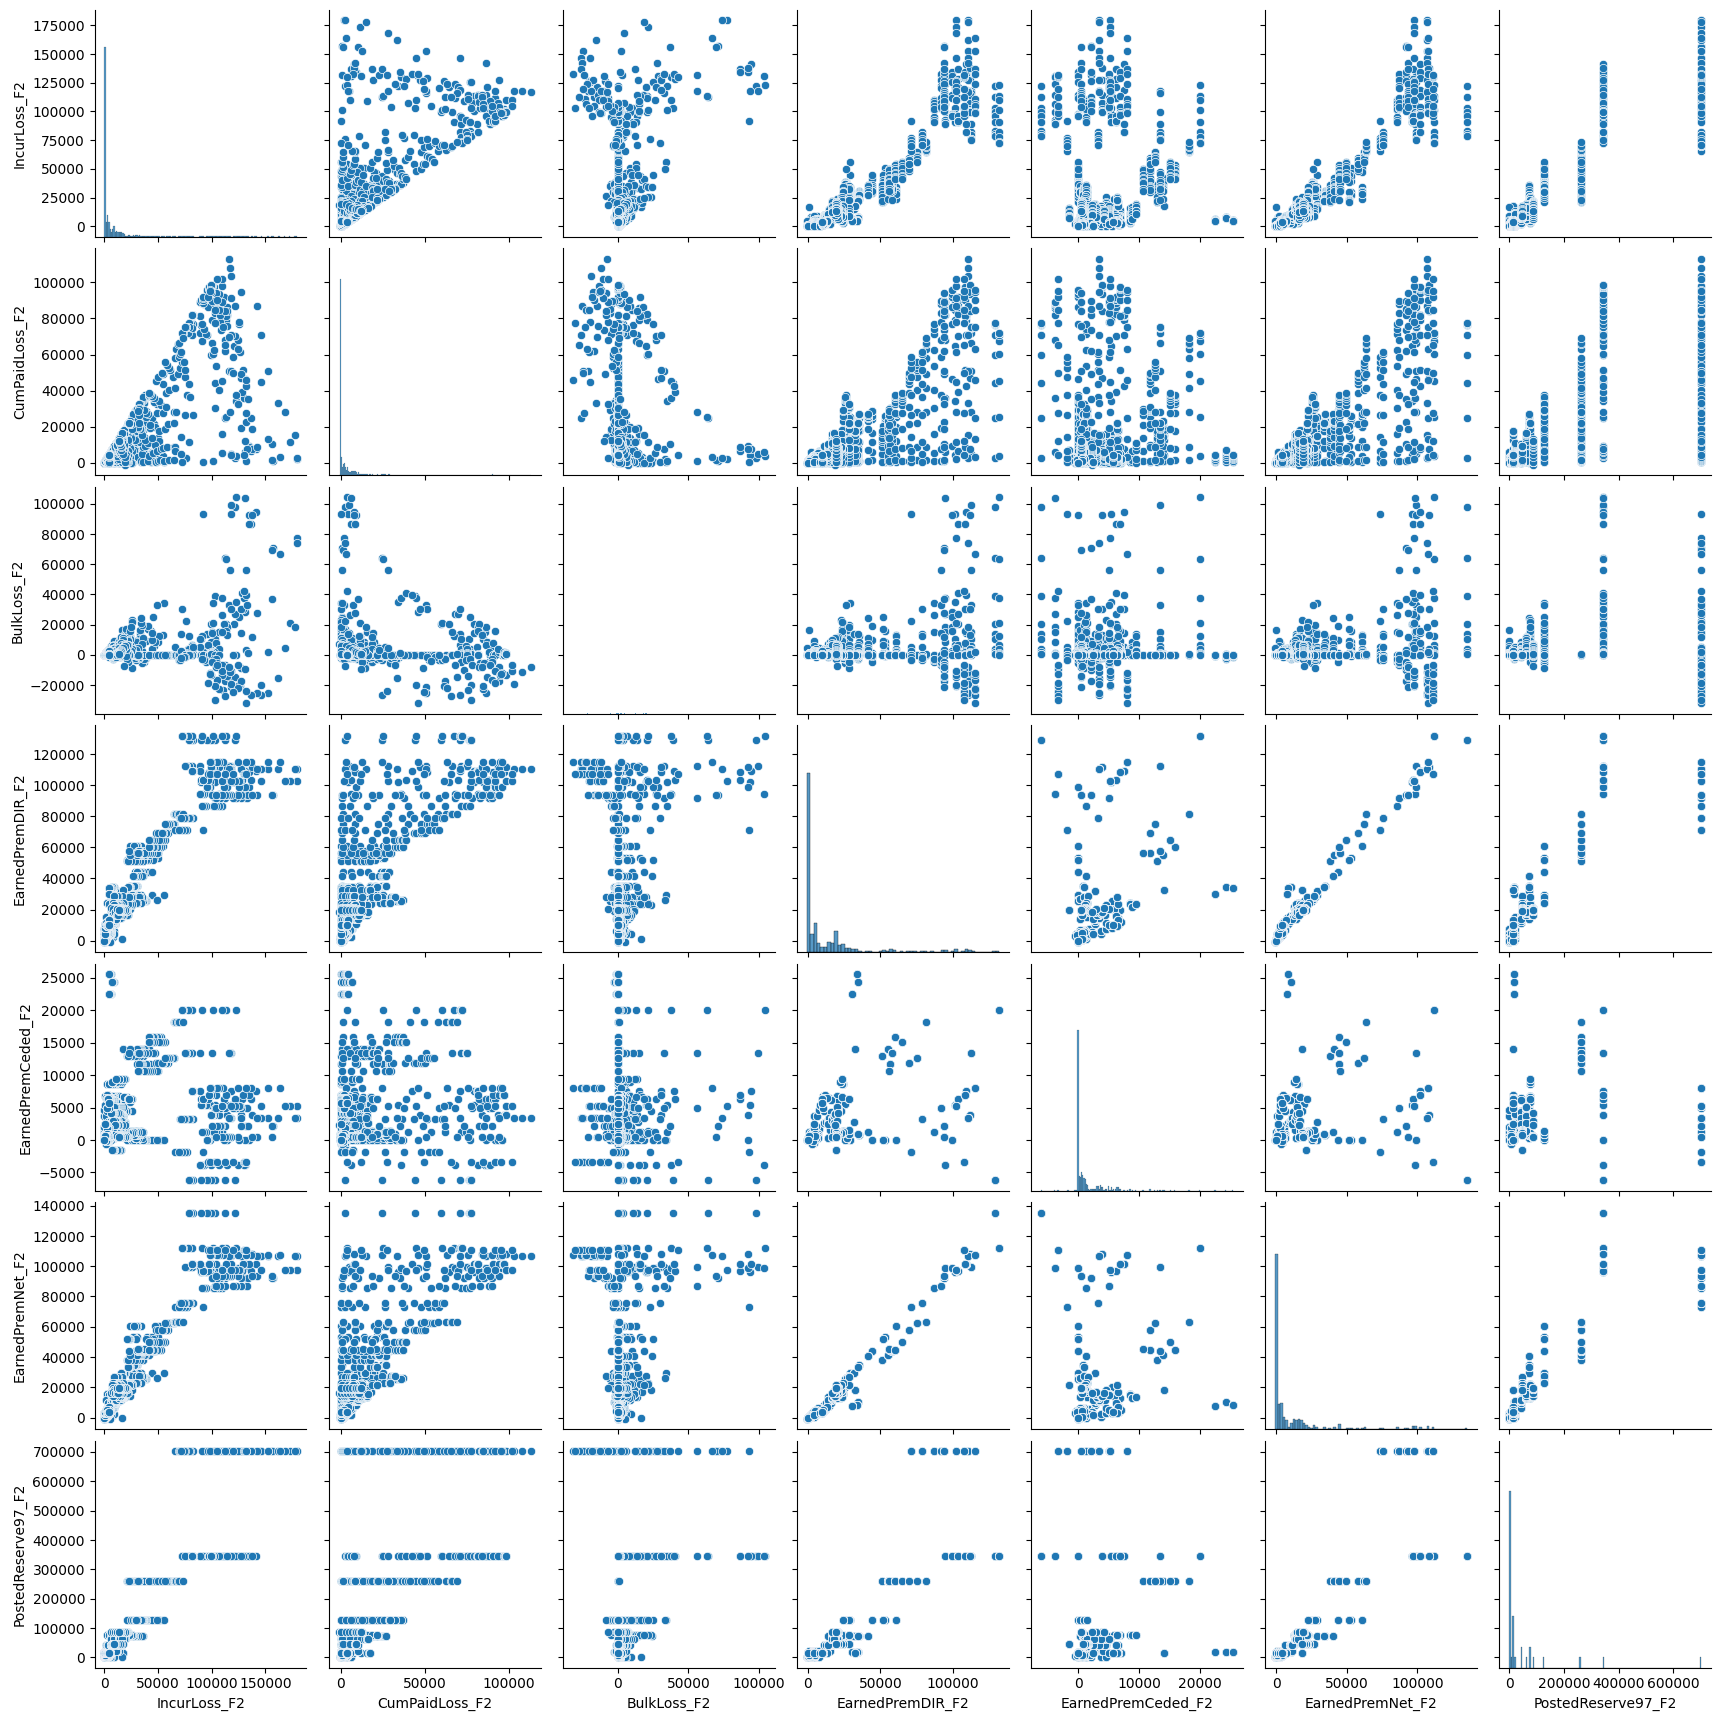

In [8]:
sns.pairplot(data_heatmap)
plt.show()

Los gráficos parecen un poco dispersos y sin una forma particular, sin embargo, tal vez al clasificar por aseguradoras individuales y de grupo, esta tendencia sea un poco más clara.

Sin embargo, se observa que hay algunas variables que tienen correlación lineal casi igual a 1, por ejemplo, *EarnedPremNet_F2* vs. *EarnedPremDIR_F2*, esto porque no tiene puntos muy desviados de la línea de tendencia, como si fueran la misma variable.

Éste fenómeno se debe a que hay una relación matemática directa entre estas variables, diferente a la línea de tendencia de esa correlación, dada por:

$\textbf{EarnedPremNet_F2} = \textbf{EarnedPremDIR_F2} - \textbf{EarnedPremCeded_F2}  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1)$

Esto es porque sus definiciones están dadas por:

*Prima directa:* Corresponde a los ingresos por la venta de seguros efectuada por el total de las compañías, rebajadas las anulaciones e incluyendo su participación en coaseguro.

*Prima cedida:* Corresponde a la parte de la prima directa o prima aceptada, que las compañías traspasan al reasegurador a través de contratos de reaseguro proporcional.

*Prima neta o retenida:* Corresponde a la prima directa, más la prima aceptada y menos la prima cedida. Es el valor neto de las primas, retenido por la aseguradora.

por lo tanto se puede decir que son la misma variable salvo una constante de subida o bajada que es la variable EarnedPremCeded_F2.
Este hecho se comprueba en el siguiente código:

In [9]:
(data.EarnedPremNet_F2 == data.EarnedPremDIR_F2 - data.EarnedPremCeded_F2).unique()[0]

True

El resto de variables que tienen una correlación positiva cercana a 1 están relacionadas con el tipo de dato y su significado. Por ejemplo, la prima, el riesgo, la pérdida y la reclamación son variables que se afectan mutuamente: a mayor prima, mayor riesgo; a mayor riesgo, mayor pérdida; y a mayor pérdida, mayor reclamación.

### A continuación se desglozarán las aseguradoras que conforman el conjunto de datos:

In [10]:
from pandas.io.excel import read_excel
cat_vars= data.select_dtypes(include="object").columns.tolist()
cod_nom = data[['GRCODE','GRNAME']].drop_duplicates()
print(cod_nom)

      GRCODE                              GRNAME
0        669                  Scpie Indemnity Co
100      683                       Promutual Grp
200      841                      Great Amer Grp
300     1406                      Nationwide Grp
400     7854                     Markel Corp Grp
500    10019       Overseas Partners Us Reins Co
600    10115         Eastern Dentists Ins Co RRG
700    10232  American Assoc Of Othodontists RRG
800    10341    Controlled Risk Ins Co Of VT Inc
900    10393                Texas Medical Ins Co
1000   10697                     MCIC VT Inc RRG
1100   10842             Franklin Cas Ins Co RRG
1200   11460                    Homestead Ins Co
1300   12260         Campmed Cas & Ind Co Inc MD
1400   13893       Community Blood Cntr Exch RRG
1500   15792       Underwriters At Lloyds London
1600   15865                        NCMIC Ins Co
1700   23663            National American Ins Co
1800   31429      Michigan Professional Ins Exch
1900   32301    Nich

| Código | Aseguradora | Año de inicio | Estado actual |
| --- | --- | --- | --- |
| 669| Scpie Indemnity Co | 1976 | Vendida a The Doctors Company en 2008 |
| 36234| Preferred Professional Ins Co | 1987 | Activa |
| 32301| Nichido Fire & Marine Ins Co Ltd | 1919 (Nichido Fire Insurance Co.) | Activa como parte de Tokio Marine Group desde 2004 |
| 32514| Texas Hospital Ins Exch | 1974 | Activa |
| 33049| State Volunteer Mut Ins Co | 1976 | Activa |
| 33111| MHA Ins Co | 1978 | Activa como parte de Coverys Group desde 2010 |
| 35904| Health Care Ind Inc | 1980 | Activa como parte de ProAssurance Group desde 2005 |
| 36072| National Guardian RRG Inc | 1989 | Activa |
| 36277| Medical Mut Ins Co Of ME | 1978 | En liquidación desde 2013 |
| 683| Promutual Grp | 1975 (Medical Professional Mutual Insurance Company) | Activa como parte de Coverys Group desde 2010 |
| 36676| Utah Medical Ins Assoc | 1978 (Utah Medical Insurance Association) | Activa como parte de The Mutual RRG Holding Company Group desde 2002. Cambió su nombre a UMIA Insurance Inc. en 2013.   |
| 40568| Seguros Triples Inc | 1983 | Activa |
| 40975| Dentists Ins Co | 1980 (California Dental Service Plan) | Activa como parte de TDIC Group desde 1983. Cambió su nombre a The Dentists Insurance Company en 1985.   |
| 41467| Physicians Recip Insurers | 1982 (Physicians' Reciprocal Insurers of New York State) | Activa bajo supervisión del Departamento de Servicios Financieros de Nueva York desde 2016. Cambió su nombre a PRI in 1998.   |
| 43656| Louisiana Med Mut Ins Co | 1981 (Louisiana Medical Mutual Insurance Company) | Activa como parte de LAMMICO Group RRG Inc. (desde 2010) y Louisiana Patient's Compensation Fund (desde 2011). Cambió su nombre a LAMMICO en 2007.   |
| 43770| Clinic Mut Ins Co RRG                 |1985 | Activa
| 31429| Michigan Professional Ins Exch        | 1987 | Activa
| 23663| National American Ins Co              | 1967 | Activa
| 15865| NCMIC Ins Co     | 1946 (National Chiropractic Mutual Insurance Company). | Activa como parte de NCMIC Group Inc. desde 1990. Cambió su nombre a NCMIC Insurance Company en 2010. Seguros para quiroprácticos.|
| 15792| Underwriters At Lloyds London         | 1688 | Activa |
| 13893| Community Blood Cntr Exch RRG         | 1993 | Activa |
| 12260| Campmed Cas & Ind Co Inc MD           | Desconocido | Activa |
| 11460| Homestead Ins Co                      | Desconocido | Activa |
| 10842| Franklin Cas Ins Co RRG               | Desconocido | Activa |
| 10697| MCIC VT Inc RRG                       | 1978 (The Medical Centre Insurance Company, Ltd.) | Activa  En 1997, MCIC Vermont y The Medical Centre Insurance Company, Ltd se fusionaron. |
| 10393| Texas Medical Ins Co                  | 1995 | Activa |
| 10341| Controlled Risk Ins Co Of VT Inc      | 1995 | Activa |
| 10232| American Assoc Of Othodontists RRG    | 1900 | Activa |
| 10115| Eastern Dentists Ins Co RRG           | 1992 | Activa |
| 10019| Overseas Partners Us Reins Co         | 1994 | Activa |
| 7854| Markel Corp Grp                       | 1930 | Activa |
| 1406| Nationwide Grp                        | 1926 | Activa |
| 841| Great Amer Grp                        | 1971 | Activa |
| 44504| California Healthcare Ins Co Inc      | 1988 | Activa |






Se puede verificar una distribución por cada aseguradora y en cada variable, sin embargo, como se notó que hay algunas variables correlacionadas, para esas las distribuciones son parecidas. veamos la distribución para cada asguradora y la variable *EarnedPremDIR_F2*:

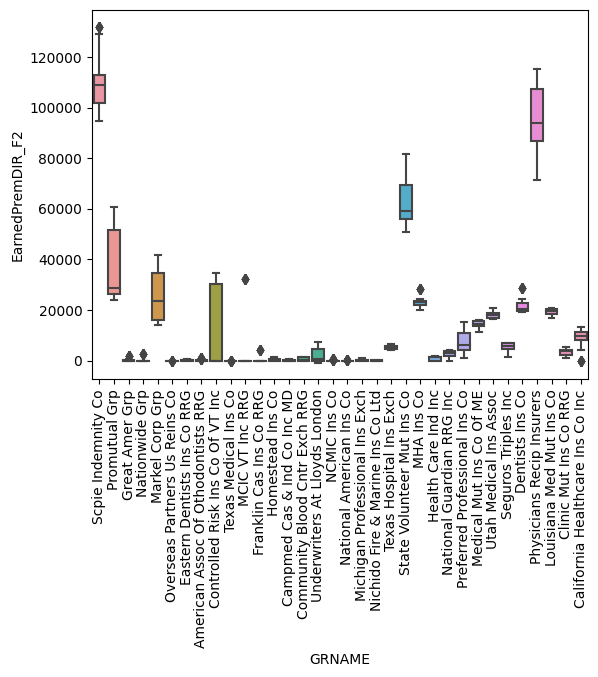

In [11]:
sns.boxplot(x="GRNAME", y="EarnedPremDIR_F2", data=data)
plt.xticks(rotation=90)
plt.show()

Como hay tanta variabilidad en esos datos, se decide separar desde este punto las aseguradoras individuales y de grupo.

#### ***Clasificación por aseguradoras individuales y de grupo:***

In [12]:
indvdl = data.iloc[np.where(data.Single==1)]
print(indvdl.GRNAME.unique())

['Overseas Partners Us Reins Co' 'Eastern Dentists Ins Co RRG'
 'American Assoc Of Othodontists RRG' 'Controlled Risk Ins Co Of VT Inc'
 'Texas Medical Ins Co' 'MCIC VT Inc RRG' 'Franklin Cas Ins Co RRG'
 'Homestead Ins Co' 'Campmed Cas & Ind Co Inc MD'
 'Community Blood Cntr Exch RRG' 'Underwriters At Lloyds London'
 'NCMIC Ins Co' 'National American Ins Co'
 'Michigan Professional Ins Exch' 'Nichido Fire & Marine Ins Co Ltd'
 'Texas Hospital Ins Exch' 'State Volunteer Mut Ins Co' 'MHA Ins Co'
 'Health Care Ind Inc' 'National Guardian RRG Inc'
 'Preferred Professional Ins Co' 'Medical Mut Ins Co Of ME'
 'Utah Medical Ins Assoc' 'Seguros Triples Inc' 'Dentists Ins Co'
 'Physicians Recip Insurers' 'Louisiana Med Mut Ins Co'
 'Clinic Mut Ins Co RRG' 'California Healthcare Ins Co Inc']


In [13]:
Grp = data.iloc[np.where(data.Single==0)]
print(Grp.GRNAME.unique())

['Scpie Indemnity Co' 'Promutual Grp' 'Great Amer Grp' 'Nationwide Grp'
 'Markel Corp Grp']


Veamos la descripción de los datos de cada conjunto, tanto las aseguradoras individuales como las de grupo:

*Aseguradoras Individuales:*

In [14]:
r(indvdl.iloc[:, np.r_[5:11, -1:0]].describe())

,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,PostedReserve97_F2
count,2900.00,2900.00,2900.00,2900.00,2900.00,2900.00,2900.00
mean,8388.25,4358.18,417.63,10578.17,1832.74,8745.43,48063.21
std,22592.81,12507.49,4869.23,20894.30,3881.61,19115.09,133588.62
min,-17.00,-1190.00,-32101.00,-781.00,-3357.00,-728.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,514.00
50%,382.00,88.00,0.00,1355.00,125.50,744.50,5203.00
75%,5939.25,3024.00,62.00,13983.00,1508.00,8163.00,20732.00
max,179425.00,113189.00,93060.00,115300.00,25553.00,110832.00,702246.00


from matplotlib import pyplot as plt
_df_0['IncurLoss_F2'].plot(kind='hist', bins=20, title='IncurLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['CumPaidLoss_F2'].plot(kind='hist', bins=20, title='CumPaidLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['BulkLoss_F2'].plot(kind='hist', bins=20, title='BulkLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['EarnedPremDIR_F2'].plot(kind='hist', bins=20, title='EarnedPremDIR_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='IncurLoss_F2', y='CumPaidLoss_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='CumPaidLoss_F2', y='BulkLoss_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='BulkLoss_F2', y='EarnedPremDIR_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='EarnedPremDIR_F2', y='EarnedPremCeded_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['IncurLoss_F2'].plot(kind='line', figsize=(8, 4), title='IncurLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['CumPaidLoss_F2'].plot(kind='line', figsize=(8, 4), title='CumPaidLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['BulkLoss_F2'].plot(kind='line', figsize=(8, 4), title='BulkLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['EarnedPremDIR_F2'].plot(kind='line', figsize=(8, 4), title='EarnedPremDIR_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

*Aseguradoras de grupo:*

In [15]:
r(Grp.iloc[:, np.r_[5:11, -1:0]].describe())

,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,PostedReserve97_F2
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,30291.70,20323.81,5029.23,34605.52,1633.88,32971.64,109279.00
std,38960.85,29498.80,15454.26,41442.18,3960.94,39664.22,126801.85
min,-10.00,-42.00,-8605.00,0.00,-6214.00,0.00,882.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,1770.00
50%,12376.00,5586.50,0.00,22791.00,3.50,18150.00,73317.00
75%,36393.25,26598.50,1830.00,51806.00,1462.00,51806.00,125868.00
max,140962.00,98655.00,104402.00,131948.00,20010.00,135318.00,344558.00


from matplotlib import pyplot as plt
_df_12['IncurLoss_F2'].plot(kind='hist', bins=20, title='IncurLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['CumPaidLoss_F2'].plot(kind='hist', bins=20, title='CumPaidLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['BulkLoss_F2'].plot(kind='hist', bins=20, title='BulkLoss_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['EarnedPremDIR_F2'].plot(kind='hist', bins=20, title='EarnedPremDIR_F2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='IncurLoss_F2', y='CumPaidLoss_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='CumPaidLoss_F2', y='BulkLoss_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='BulkLoss_F2', y='EarnedPremDIR_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='EarnedPremDIR_F2', y='EarnedPremCeded_F2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['IncurLoss_F2'].plot(kind='line', figsize=(8, 4), title='IncurLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['CumPaidLoss_F2'].plot(kind='line', figsize=(8, 4), title='CumPaidLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_22['BulkLoss_F2'].plot(kind='line', figsize=(8, 4), title='BulkLoss_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['EarnedPremDIR_F2'].plot(kind='line', figsize=(8, 4), title='EarnedPremDIR_F2')
plt.gca().spines[['top', 'right']].set_visible(False)

Los datos siguen conservando una desviación bastante alta, así que por el momento no haremos clasificación por aseguradoras de grupo o individual, porque parece no haber cierta distinción.

### *Construcción de triángulos run off para cada aseguradora y para cada variable*

In [16]:
def correla(matrices,m,n):
  correlacion = np.zeros((10, 10))
  matrices = np.array(matrices)
  for i in range(10):
      for j in range(10):
          # Extraer el vector de la posición i,j
          vector = matrices[:,i,j]
          # Calcular el coeficiente de correlación con el vector de la posición 0,0
          coeficiente = np.corrcoef(vector, matrices[:,m,n])[0,1]
          # Guardar el coeficiente en la posición i,j del array correlacion
          correlacion[i,j] = coeficiente
  correlacion = np.round(correlacion, 4)
  return correlacion

def central_metrics(matrices,columns,rows):
  # Calcular la media de la lista de matrices, especificando el eje 0
  media = np.round(np.mean(matrices, axis=0), 1)
  media = pd.DataFrame(media, columns=columns, index=rows)

  std = np.round(np.std(matrices, axis=0), 1)
  std = pd.DataFrame(std, columns=columns, index=rows)

  correlacion88 = correla(matrices,0,0)
  correlacion92 = correla(matrices,4,4)
  correlacion97 = correla(matrices,9,9)


  correlacion88 = pd.DataFrame(correlacion88, columns=columns, index=rows)
  correlacion92 = pd.DataFrame(correlacion92, columns=columns, index=rows)
  correlacion97 = pd.DataFrame(correlacion97, columns=columns, index=rows)

  print("\n\n ******************** Matriz Media ********************\n")
  print(media)
  print("\n\n ******************** Matriz Desviación estándar ********************\n")
  print(std)
  print("\n\n ******************** Matriz Correlación ********************\n")
  print("\n Respecto a 1988:\n",correlacion88)
  print("\n Respecto a 1992:\n",correlacion92)
  print("\n Respecto a 1997:\n",correlacion97)


def triang_for_var(data, col_validation):
  matrices = []
  rows = ['1988','1989','1990','1991','1992','1993','1994','1995','1996','1997']
  columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
  print("VARIABLE: ",col_validation )
  ## Triángulos por aseguradora
  k=0
  for i in data.GRCODE.unique():
    print("\n ************************ \n Nombre:",data.GRNAME.iloc[np.where(data.GRCODE==i)].unique()[0])
    print("\n Código: ",i,"\n")
    globals()["Aseg_"+str(i)+"_"+col_validation]=data.iloc[np.where(data.GRCODE==i)]

    # Triángulos de run off
    globals()["Aseg_"+str(i)+"_"+col_validation] = globals()["Aseg_"+str(i)+"_"+col_validation].pivot(index='AccidentYear', columns='DevelopmentLag', values=col_validation)
    matrices.append(globals()["Aseg_"+str(i)+"_"+col_validation].to_numpy())
    k+=1
    print(globals()["Aseg_"+str(i)+"_"+col_validation])

  print(f"\n\n Hay {k} aseguradoras")
  central_metrics(matrices,columns,rows)

  return matrices


\

\


### *IncurLoss_F2:*

muestra la situación de las pérdidas de las aseguradoras. De ellas se tiene:

2 aseguradoras tienen pérdidas nulas en todas las entradas y una de ellas, pérdidas muy bajas en el año más actual de la muestra, lo que significa que no registraron pérdidas en este periodo. Esto se explica porque iniciaron sus actividades en 1994 y 1995, respectivamente, y aún no se han consolidado en el mercado de seguros ni han recibido reclamaciones en este breve lapso de 3 y 2 años.

3 aseguradoras no reportan pérdidas en los años más recientes de la muestra. Esto podría deberse a que son compañías con mucha trayectoria en el mercado, fundadas en 1688, 1967 y 1980, respectivamente. Al tener una buena posición económica, pueden asumir deducibles altos y no registrar pérdidas menores. Además, pueden hacer mejores estimaciones de las pérdidas y contar con coseguros para cubrirlas, lo que reduce el impacto de los siniestros.

14 aseguradoras registran pérdidas nulas en los primeros años de la muestra. Esto puede obedecer a dos situaciones: que sean aseguradoras nuevas que tardan en recibir reclamaciones o que sean aseguradoras con gran capacidad de mercado que no consideran pérdidas menores. No obstante, puede haber cambios en las políticas internas de las compañías que hagan que las pérdidas pasen a ser positivas en algún momento. Por ejemplo, al evaluar el valor de las pérdidas y compararlo con los posibles coseguros, puede resultar más conveniente reportar las pérdidas.

El resto de las aseguradoras reportan pérdidas positivas. Esto indica que han tenido reclamaciones que han cubierto con sus reservas y su solvencia económica, sin importar su antigüedad o su posición en el mercado asegurador.

Solo una aseguradora, *Homestead Ins Co*, reporta pérdidas negativas en el año 1993 y en los rezagos de 7 a 10 años. Esto podría deberse a que se modificó el valor de las pérdidas por alguna razón legal o a que hubo un excedente de liquidez. Con el tiempo, estas pérdidas se ajustaron al valor previamente calculado.

***Matriz media y de desviación estándar:*** La media y desviación estándar de esta variable por cada entrada de las matrices muestran una tendencia creciente desde la esquina superior derecha hasta la inferior izquierda. Esto se explica por dos factores: el primero es el periodo de los rezagos, ya que las compañías suelen pagar más en los años cercanos a la reclamación; el segundo es el tiempo de reclamación, que implica que las reclamaciones se encarecen por efectos económicos como la inflación, la devaluación y otros cambios en los mercados.

***Matriz de correlación:*** Se observa que cada posición en las matrices tiene una correlación con el resto de las entradas. Esta correlación es más fuerte para los años más próximos al año estudiado. Se analizan 3 años (1988, 1992 y 1997) y se confirma que las correlaciones más altas se dan entre los años cercanos. Sin embargo, la correlación entre los otros años tampoco es muy baja, lo que sugiere que hay una relación entre todos los años. Con esta tendencia de correlación, se puede implementar el modelo de predicción para los años siguientes.

***Nota:**** *Por ahora se considerarán todos los elementos para el cálculo de estas métricas, pero en principio, teniendo en cuenta que hay aseguradoras que no estaban presentes en el mercado durante un intervalo de tiempo, tener en cuenta estos valores de cero sería sesgar la muestra. para tener un análisis específico del monto pagado y reportado como pérdida, se deberían excluir todos los valores de 0, en los tiempos tales que las aseguradoras no existen.*

In [17]:
col_validation='IncurLoss_F2'
m_incurloss = triang_for_var(data, col_validation)

VARIABLE:  IncurLoss_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1       2       3       4       5      6      7      8      9      10
AccidentYear                                                                             
1988            121905  112211  103226   99599   96006  90487  82640  80406  78920  78511
1989            122679  113165  110037  101142   90817  81919  77491  73577  72716  72317
1990            118157  117497  116377   99895   89252  81916  79134  76333  75612  75350
1991            117981  122443  121056  113795  102830  98071  94870  91062  90493  90345
1992            131059  130155  124195  113974  106817  99182  92588  91000  89256  89251
1993            134700  130757  125253  114717  111294  98014  96872  95714  96017  96047
1994            136749  128192  121355  111877   96152  91502  90498  91870  91848  91938
1995            140962  132405  118332  100050   88809  82360  81986  81887  81796  81782
199

\

\


### *CumPaidLoss_F2:*

Los argumentos para esta variable son análogos a los anteriores por ser variables de pérdidas, solo que en la variable *IncurLoss_F2* es la pérdida en el tiempo t con un rezago de x y para la variable *CumPaidLoss_F2* es el acumulado, en el mismo tiempo t y un rezago de x.


In [18]:
col_validation='CumPaidLoss_F2'
m_cumpaidloss = triang_for_var(data, col_validation)

VARIABLE:  CumPaidLoss_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag    1      2      3      4      5      6      7      8      9      10
AccidentYear                                                                       
1988            2716  24576  43990  59722  71019  76354  76792  77207  77588  77656
1989            3835  25158  45145  60331  67457  70821  71769  72085  72035  72171
1990            4838  27965  50873  66400  71875  74755  75176  75250  75250  75250
1991            4456  34241  64737  79390  84465  87375  89119  89825  90333  90343
1992            5970  36080  68268  81783  86076  87167  88282  88857  89087  89102
1993            9398  46210  77045  86298  91796  93827  95871  95943  95987  96008
1994            6181  39204  70006  82385  86523  88387  90408  90525  91640  91796
1995            7828  42356  70729  79340  81142  81891  81905  81897  81781  81782
1996            8854  51400  81653  90504  94284  96456  9730

\

\


#### *BulkLoss_F2:*

Esta variable muestra la situación de las reservas establecidas para cubrir pérdidas futuras que se espera que surjan de eventos pasados pero que aún no se han notificado. De ellas se tiene:

- 3 aseguradoras tienen reservas nulas en todas las entradas, incluyendo las dos aseguradoras de las variables anteriores que tienen ceros en todas sus componentes por ser tan nuevas en el mercado. La aseguradora adicional es *Great Amer Grp*, la cual inició actividades en 1971. Esto implica que estas aseguradoras no han tenido siniestros con demora en el aviso, otra posible razón es que han estimado correctamente el costo total de los siniestros ocurridos en el pasado y no tenga ninguna reserva adicional para cubrir siniestros no avisados. Esto podría deberse a que la compañía tenga una buena gestión de riesgos, un control eficiente de los procesos de reclamación y una base de datos confiable y actualizada, por otro lado, podría suceder, que la compañía haya utilizado una metodología de cálculo de la reserva de siniestros ocurridos no avisados que sea muy conservadora y que haya liberado el exceso de reserva en el periodo actual

- 6 aseguradoras registran reservas nulas en casi toda la muestra, lo que sugiere que estas aseguradoras han tenido una baja frecuencia o severidad de los siniestros o que han ajustado sus políticas de suscripción y tarificación para reducir la incertidumbre sobre el costo final de los siniestros.

- 7 aseguradoras no reportan reservas en los años más recientes de la muestra, lo que puede deberse a un cambio en la metodología de cálculo o a una falta de información actualizada sobre los siniestros ocurridos en el pasado.

- 10 aseguradoras registran reservas nulas en los primeros años de la muestra, lo que puede reflejar una mayor incertidumbre sobre el costo final de los siniestros o una mayor demora en el aviso en esos periodos.

La existencia o no de reservas de siniestros ocurridos no avisados tiene implicaciones para la solvencia y rentabilidad de las aseguradoras, pero también puede ser un riesgo si se produce un cambio adverso en la frecuencia o severidad de los siniestros, o si se presentan reclamaciones inesperadas por eventos pasados.

Los valores negativos, presentes en 14 aseguradoras, de las cuales 5 presentan este patrón negativo por largor periodos de tiempo, pueden hacer referencia a una necesidad de liquidez en la reserva, la cual para esa fecha estaba ausente, o que la compañía haya sobreestimado el monto de las reservas necesarias en el pasado y haya realizado ajustes a la baja en el presente. Esto puede ocurrir, por ejemplo, cuando se resuelven reclamaciones con un costo menor al esperado o cuando se reduce la frecuencia o la severidad de los siniestros.

***Matriz media:*** La media de esta variable por cada entrada de las matrices muestra una tendencia decreciente desde la esquina superior izquierda hasta la inferior derecha, exceptuando algunos casos. Es decir, la media de esta variable es mayor para los rezagos más cortos y los tiempos de reclamación más largos, ya que esto implica que hay más siniestros ocurridos en el pasado que aún no han sido notificados y que requieren una reserva y además que a partir de la historia las aseguradoras han mejorado su modelo de estimación de reservas. Por el contrario, la media sea menor para los rezagos más largos y los tiempos de reclamación más cortos, ya que esto implica que hay menos siniestros ocurridos en el pasado que aún no han sido notificados y que requieren una reserva.


***Desviación estándar:*** La desviación estándar se mantiene casi constante sobre el año de rezago, pero disminuye a medida que éste rezago aumenta, y con ello la variabilidad en ese rezago, respecto a los años de reclamación, va aumentando. Esto se debe a que los siniestros con rezagos más largos son menos frecuentes y más predecibles que los siniestros con rezagos más cortos, lo que reduce la incertidumbre sobre el costo final de los mismos. Por el contrario, los siniestros con rezagos más cortos son más frecuentes y menos predecibles que los siniestros con rezagos más largos, lo que aumenta la incertidumbre sobre el costo final de los mismos.


***Matriz de correlación:*** En este caso, se observa que los valores cercanos tanto en tiempo de reclamación como de rezago tienen una correlación alta cercana a 1, pero a medida que se alargan los años, este coeficiente disminuye tan rápido hasta llegar a valores negativos. Esto se debe a que los siniestros con tiempos de reclamación y rezagos similares tienen características comunes que afectan el costo final de los mismos, como la frecuencia, la severidad, la inflación, la normatividad, etc. Por el contrario, los siniestros con tiempos de reclamación y rezagos muy diferentes tienen características distintas que afectan el costo final de los mismos, lo que genera una divergencia o una inversión en la tendencia de los valores de la variable.



In [19]:
col_validation='BulkLoss_F2'
m_bulkloss = triang_for_var(data, col_validation)

VARIABLE:  BulkLoss_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1      2      3      4      5      6     7     8    9    10
AccidentYear                                                                   
1988             97966  64117  39008  20736  13599  10577  3762  2105  819  407
1989            104402  63198  37567  21284  12614   6276  3915  1311  539   58
1990             99473  56076  32771  15125  10652   5861  3857  1057  336   74
1991             93508  34866  20295  20724  10313   6756  4403   488  138    2
1992            103660  37632  26737  18537  14900   8312  1495   768  109   87
1993             92455  28503  25047  18165  15626   2699   911  -229   30   39
1994             86894  40794  26847  20401   6253   2064   -36     0   30   11
1995             94269  39510  30430  14715   5435    385    77    48   15    0
1996             86910  30659  15815   7588   1705    435    -5   162  171   23
1997             92560  

\

\


###  *PRIMAS GANADAS:*

Los valores de estas tres variables, (EarnedPremDIR_F2, EarnedPremCeded_F2, EarnedPremNet_F2), están relacionados bajo la ecuación 1. Los triángulos asociados muestran las primas que la aseguradora ha reconocido como ingresos en el año de incurrimiento de los siniestros, es decir, el año en que se producen los eventos que dan lugar a las reclamaciones. Estas primas se mantienen constantes en todas las filas, ya que no dependen del año de desarrollo de los siniestros, es decir, el año en que se notifican o se pagan las reclamaciones. Las primas ganadas solo cambian cuando se produce una modificación en el contrato de seguro o en la cartera de clientes, lo que puede generar valores negativos en algunos casos. Por lo tanto, los triángulos de primas ganadas reflejan la exposición al riesgo de la aseguradora en el año de incurrimiento, independientemente del tiempo que tarde en conocer el costo final de los siniestros.

Los valores nulos en estos triángulos pueden tener diferentes interpretaciones según el contexto. Por ejemplo:

* Si los valores nulos corresponden a años anteriores a la constitución de la aseguradora, significa que no hay datos disponibles sobre las primas ganadas en esos años, ya que la aseguradora no tenía actividad en el mercado.

* Si los valores nulos corresponden a años posteriores al cierre de la muestra, como si la aseguradora hubiera sido vendida o fusionada o hubiera cambiado su razón social o su régimen contable, significa que la aseguradora ha dejado de reportar las primas ganadas en esos años, ya que ha cesado su operación o ha modificado su estructura jurídica o contable.

En cualquier caso, los valores nulos en estos triángulos implican una ausencia de datos que puede dificultar el análisis de la relación entre las primas y las pérdidas. Por lo tanto, es importante identificar la causa de los valores nulos y tratar de obtener o estimar los datos faltantes si es posible. Sin embargo, dado que no se pueden recolectar esos datos de ninguna manera, la opción más viable es limpiar la muestra, eliminando algunos años de algunas aseguradoras o eliminando algunas aseguradoras por completo. Esto será fundamental para describir exactamente los riesgos que asume la aseguradora y no incluir valores que no son reales, que sesgarían la muestra hacia abajo (cerca al cero) y no permitirían percibir patrones y tendencias relevantes para el mejor desarrollo de un modelo predictivo de provisiones.

Se observa que la media aumenta para estas variables y esto se debe a efectos de inflación, devaluación, crecimiento del riesgo de las primas aseguradas, etc. Estos factores hacen que las primas ganadas sean mayores en los años más recientes que en los años más antiguos, lo que refleja un incremento en el nivel de ingresos de la aseguradora.

Para las variables EarnedPremDIR_F2 y EarnedPremNet_F2 la desviación se mantiene casi que constante durante los años de la muestra y la correlación entre todos los años es bastante alta, lo que indica que los valores de estas variables tienen una distribución homogénea y una relación lineal positiva fuerte. Esto significa que las primas directas y netas tienden a moverse en la misma dirección y proporción, lo que implica una estabilidad en el nivel de riesgo asumido por la aseguradora.

Sin embargo, para EarnedPremCeded_F2 la desviación tiende a aumentar al pasar los años y la correlación tiende a llegar a niveles más bajos para estimar una correlación entre variables, ya sea positiva o negativa. Esto indica que los valores de esta variable tienen una distribución heterogénea y una relación lineal débil o nula. Esto significa que las primas cedidas tienden a moverse en direcciones o proporciones diferentes, lo que implica una variabilidad en el nivel de riesgo transferido por la aseguradora.

#### *EarnedPremDIR_F2:*

In [20]:
col_validation='EarnedPremDIR_F2'
m_earnedpremdir = triang_for_var(data, col_validation)

VARIABLE:  EarnedPremDIR_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1       2       3       4       5       6       7       8       9       10
AccidentYear                                                                                  
1988            129104  129104  129104  129104  129104  129104  129104  129104  129104  129104
1989            131948  131948  131948  131948  131948  131948  131948  131948  131948  131948
1990            112742  112742  112742  112742  112742  112742  112742  112742  112742  112742
1991            101814  101814  101814  101814  101814  101814  101814  101814  101814  101814
1992             94694   94694   94694   94694   94694   94694   94694   94694   94694   94694
1993             99099   99099   99099   99099   99099   99099   99099   99099   99099   99099
1994            103343  103343  103343  103343  103343  103343  103343  103343  103343  103343
1995            109098  109098  109098  1090

\
#### *EarnedPremCeded_F2:*

In [21]:
col_validation='EarnedPremCeded_F2'
m_earnedpremceded = triang_for_var(data, col_validation)

VARIABLE:  EarnedPremCeded_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag     1      2      3      4      5      6      7      8      9      10
AccidentYear                                                                        
1988            -6214  -6214  -6214  -6214  -6214  -6214  -6214  -6214  -6214  -6214
1989            20010  20010  20010  20010  20010  20010  20010  20010  20010  20010
1990            13449  13449  13449  13449  13449  13449  13449  13449  13449  13449
1991             5331   5331   5331   5331   5331   5331   5331   5331   5331   5331
1992            -3914  -3914  -3914  -3914  -3914  -3914  -3914  -3914  -3914  -3914
1993              -34    -34    -34    -34    -34    -34    -34    -34    -34    -34
1994             6246   6246   6246   6246   6246   6246   6246   6246   6246   6246
1995             7498   7498   7498   7498   7498   7498   7498   7498   7498   7498
1996             6927   6927   6927   6927   69

\
#### *EarnedPremNet_F2:*

In [22]:
col_validation_1='EarnedPremNet_F2'
m_earnedpremnet = triang_for_var(data, col_validation_1)

VARIABLE:  EarnedPremNet_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1       2       3       4       5       6       7       8       9       10
AccidentYear                                                                                  
1988            135318  135318  135318  135318  135318  135318  135318  135318  135318  135318
1989            111938  111938  111938  111938  111938  111938  111938  111938  111938  111938
1990             99293   99293   99293   99293   99293   99293   99293   99293   99293   99293
1991             96483   96483   96483   96483   96483   96483   96483   96483   96483   96483
1992             98608   98608   98608   98608   98608   98608   98608   98608   98608   98608
1993             99133   99133   99133   99133   99133   99133   99133   99133   99133   99133
1994             97097   97097   97097   97097   97097   97097   97097   97097   97097   97097
1995            101600  101600  101600  1016

\

\


###  *PostedReserve97_F2:*


Las reservas publicadas son iguales en todas las filas y columnas porque corresponden al valor reportado por la aseguradora en el año 1997, que es el año base de la muestra. Este valor no cambia según el año de desarrollo de los siniestros, es decir, el año en que se notifican o se pagan las reclamaciones. Las reservas publicadas solo cambian cuando se produce una revisión de las estimaciones de reservas, lo que puede generar valores negativos en algunos casos. Por lo tanto, los triángulos de reservas publicadas reflejan el nivel de pasivo de la aseguradora en el año 1997, independientemente del tiempo que tarde en conocer el costo final de los siniestros.

En esta muestra se tiene 5 aseguradoras con valores nulos en su matriz, donde 2 de ellas son las aseguradoras más actuales del mercado.Por lo tanto, los valores nulos en estos triángulos tienen diferentes interpretaciones según el contexto:

- Si los valores nulos corresponden a aseguradoras nuevas, se debe a la demora en la constitución de la aseguradora, y por ende no hay datos disponibles sobre las reservas publicadas, ya que la aseguradora no tenía actividad en el mercado.

- Si los valores nulos corresponden a aseguradoras muy antiguas, como si la aseguradora hubiera sido vendida o fusionada o hubiera cambiado su razón social o su régimen contable, significa que la aseguradora ha dejado de reportar las reservas publicadas en esos años, ya que ha cesado su operación o ha modificado su estructura jurídica o contable.

Esto puede afectar el análisis de la evolución de las reservas y su relación con los siniestros, ya que se desconoce el nivel de pasivo final de la aseguradora.

In [23]:
col_validation='PostedReserve97_F2'
m_postedreserve = triang_for_var(data, col_validation)

VARIABLE:  PostedReserve97_F2

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1       2       3       4       5       6       7       8       9       10
AccidentYear                                                                                  
1988            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1989            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1990            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1991            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1992            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1993            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1994            344558  344558  344558  344558  344558  344558  344558  344558  344558  344558
1995            344558  344558  344558  34

## **Conclusión:**

Luego de un exhaustivo análisis de las variables en el contexto de nuestro proyecto de triángulos de runoff de compañías aseguradoras, se ha llegado a las siguientes conclusiones:

1. Hay dos aseguradoras en particular, a saber, *Overseas Partners Us Reins Co* y *Texas Medical Ins Co*. Estas compañías presentan un alto número de valores nulos en las variables estudiadas debido a su reciente ingreso al mercado en el momento en que se tomó la muestra. Su falta de suficiente cobertura para reportar pérdidas se refleja en el valor nulo o extremadamente bajo de las primas netas durante los años considerados.

2. En contraste, algunas otras aseguradoras, como *Controlled Risk Ins Co Of VT Inc* y *Community Blood Cntr Exch RRG*, también son relativamente nuevas en el mercado. Sin embargo, estas compañías tienen una posición lo suficientemente establecida en el mercado como para reportar pérdidas (incluso negativas) durante los períodos de cobertura incluidos en la muestra.

3. En cuanto a las demás aseguradoras que presentan valores nulos en todas las variables. Estos valores reflejan información real en los períodos existentes de las compañías y pueden representar situaciones como la liquidación de la compañía, cambios en la razón social o períodos inexistentes al comienzo del período considerado en la muestra. Modificar estos ceros mediante imputación o eliminación podría distorsionar la integridad de los datos y llevar a conclusiones erróneas.

Se diseñará un modelo que incluya todas las aseguradoras disponibles, y luego se hará un análisis de sensibilidad o de escenarios para ver cómo cambian los resultados excluyendo algunas aseguradoras.

Recordando que podría haber alguna relación entre el tamaño, el tipo, la ubicación o el segmento de mercado de las aseguradoras y sus matrices de runnoff, variables para las cuales, en primera instancia no se tiene información y que en realidad no se necesitan por ser un proyecto de predicción y no de inferencia o causalidad.

Estas acciones, permitirán un análisis más preciso de la relación entre las primas y las pérdidas en el contexto del proyecto. Además, estas decisiones mejorarán la calidad de nuestro análisis y la confiabilidad de los resultados obtenidos.

Relativo a las variables a considerar, se tiene:

* Se usará ***IncurLoss_*** como la variable principal para el cálculo de las reservas, ya que representa las pérdidas totales que la aseguradora ha experimentado hasta la fecha.

* Como, ***CumPaidLoss_*** representa las pérdidas que ya se han pagado a los asegurados, se usará la diferencia entre *IncurLoss_* y *CumPaidLoss_* como una medida de las reservas pendientes de pago, y se comparará con la variable ***BulkLoss_***. Esta comparación ayuda a verificar si hay alguna diferencia significativa o alguna tendencia en el tiempo. Es decir, identificar posibles subestimaciones o sobreestimaciones de las reservas.

* Se dejará solo la variable ***EarnedPremNet_***, ya que representa las primas ganadas netas de la cesión al reaseguro, y que son la base para determinar la relación entre las primas y las pérdidas. Se eliminará *EarnedPremDIR_* y *EarnedPremCeded_*, ya que son variables redundantes que se pueden deducir a partir de *EarnedPremNet_*. Además, se calculará el ratio de siniestralidad, que es la relación entre *IncurLoss_* y *EarnedPremNet_*, ya que es un indicador clave de la rentabilidad de la aseguradora.

* se usará la variable ***BulkLoss_*** como una variable auxiliar para el cálculo de las reservas, ya que representa las reservas establecidas para cubrir pérdidas futuras que se espera que surjan de eventos pasados pero que aún no se han notificado.

* La variable ***PostedReserve97_*** se usará como una variable de referencia para el cálculo de las reservas, ya que representa las reservas publicadas en el año 1997, que es el año base de la muestra. Se puede comparar esta variable con la diferencia entre *IncurLoss_* y *CumPaidLoss_*, para ver si hay alguna diferencia significativa o alguna tendencia en el tiempo. Esto podría ayudar a identificar posibles revisiones al alza o a la baja de las reservas.


## ***Data Preparation***

Eventualmente se sacarán del modelo de predicción las variables *EarnedPremDIR_F2*, *EarnedPremCeded_F2* por ser variables redundantes, *Single* por ser una variable no contemplada debido a que ya se hizo una previa clasificación con esta variable y no se notó relativa diferencia en las distribuciones de estos conjuntos de datos, y *PostedReserve97_F2* por ser una variable constante en todas las entradas de la matriz, por ser la reserva publicada de 1997.

Por otro lado, se generarán nuevas variables derivadas a partir de las existentes, dadas por el ratio de siniestralidad (IncurLoss_F2 / EarnedPremNet_F2) y la diferencia entre IncurLoss_ y CumPaidLoss_.

### Ratio de siniestralidad:
Note que esta variable está bien definida solo si *EarnedPremNet_F2* $\neq 0$. Si *EarnedPremNet_F2* $= 0$ hay dos posibles casos:

1. *IncurLoss_F2* = 0, lo cual sería natural, un año o una época en la que no hay reclamos y tampoco hay primas es porque no hay cobertura de algún tipo y por ende no hay riesgo, este es el caso trivial. Para este caso el radio de siniestralidad se define como 0.

2. *IncurLoss_F2* $\neq 0$, esto se puede dar por varios factores:

* La póliza de seguro es nueva y aún no se ha cobrado ninguna prima, pero ya se ha producido alguna reclamación.

* La póliza de seguro ha sido cancelada o rescindida, y se ha devuelto la prima al asegurado, pero aún hay reclamaciones pendientes de pago.

* La póliza de seguro tiene una cláusula de participación en beneficios o pérdidas, y la aseguradora ha devuelto parte o toda la prima al asegurado en función del resultado del negocio.

* La póliza de seguro tiene una estructura de pago diferido o variable, y la prima se ajusta en función del rendimiento del negocio o de algún índice externo.

En estos casos, el ratio de siniestralidad será indefinido. Por lo tanto, la medida de la media no será descriptiva en esta variable, pero se podrían considerar la mediana o los cuartiles, que proporcionarán información relevante sobre la relación.


### Eliminar columnas de variables innecesarias y agregar las necesarias.

In [24]:
columnas = list(range(3)) + list(range(4, 8)) + list(range(10, 11))
data_new = data.iloc[:, columnas]
condition = ((data_new['EarnedPremNet_F2'] == 0) & (data_new['IncurLoss_F2'] == 0)) | (data_new['EarnedPremNet_F2'] == 0)

data_new['IncurLoss_PremNet_ratio'] = 0
# Si EarnedPremNet_F2 es igual a 0 y IncurLoss_F2 es igual a 0, asigna 0
data_new.loc[condition, 'IncurLoss_PremNet_ratio'] = 0
# Para todos los demás casos, calcula la fracción o razón
data_new.loc[~condition, 'IncurLoss_PremNet_ratio'] = data_new['IncurLoss_F2'] / data_new['EarnedPremNet_F2']

data_new.loc[:, "diff_Incur_Paid_Loss"] = data_new["IncurLoss_F2"] - data_new["CumPaidLoss_F2"]
data_new


,GRCODE,GRNAME,AccidentYear,DevelopmentLag,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremNet_F2,IncurLoss_PremNet_ratio,diff_Incur_Paid_Loss
0,669,Scpie Indemnity Co,1988,1,121905,2716,97966,135318,0.900878,119189
1,669,Scpie Indemnity Co,1988,2,112211,24576,64117,135318,0.829239,87635
2,669,Scpie Indemnity Co,1988,3,103226,43990,39008,135318,0.762840,59236
3,669,Scpie Indemnity Co,1988,4,99599,59722,20736,135318,0.736037,39877
4,669,Scpie Indemnity Co,1988,5,96006,71019,13599,135318,0.709484,24987
...,...,...,...,...,...,...,...,...,...,...
3395,44504,California Healthcare Ins Co Inc,1997,6,3970,3971,-1,4007,0.990766,-1
3396,44504,California Healthcare Ins Co Inc,1997,7,3965,3965,0,4007,0.989518,0
3397,44504,California Healthcare Ins Co Inc,1997,8,3965,3965,0,4007,0.989518,0
3398,44504,California Healthcare Ins Co Inc,1997,9,3965,3965,0,4007,0.989518,0


In [25]:
r(data_new.describe())

,GRCODE,AccidentYear,DevelopmentLag,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremNet_F2,IncurLoss_PremNet_ratio,diff_Incur_Paid_Loss
count,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00,3400.00
mean,22809.76,1992.50,5.50,11609.34,6706.07,1095.80,12308.11,0.47,4903.28
std,14708.38,2.87,2.87,26802.82,17121.82,7612.67,24824.23,2.34,16716.53
min,669.00,1988.00,1.00,-17.00,-1190.00,-32101.00,-728.00,-93.34,-275.00
25%,10341.00,1990.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,19764.00,1992.50,5.50,645.00,187.00,0.00,1302.00,0.48,10.50
75%,36234.00,1995.00,8.00,9050.50,4385.50,107.25,13490.00,0.86,1652.50
max,44504.00,1997.00,10.00,179425.00,113189.00,104402.00,135318.00,84.00,177246.00


Es fundamental destacar la variable *IncurLoss_PremNet_ratio*, que muestra que en el percentil 75%, su valor asciende a un 87.57%. Este porcentaje representa la proporción de la prima neta destinada a cubrir pérdidas. Por lo tanto, en ciertos casos, resulta crucial llevar a cabo una evaluación más detallada de los riesgos con el fin de evitar la presencia de un porcentaje tan elevado en este percentil. Un indicador más favorable se encuentra en el percentil 50%, donde el 50% de la prima se destina al pago de reclamaciones. Este enfoque tiende a ser menos impactante y más sostenible en términos de gestión de riesgos.

En el percentil 25%, se presenta un caso completamente favorable en el que el 0% de la prima se destina al pago de reclamaciones. No obstante, también existen casos extremos, como el valor infinito mencionado anteriormente y valores negativos. Los valores negativos pueden originarse por dos razones: una prima negativa o una reclamación negativa. En el primer caso, si la prima es negativa y la reclamación es positiva, se generan pérdidas en ambas áreas. En el segundo caso, un valor negativo de reclamación representa un ingreso para la compañía de seguros, al igual que una prima positiva. Este último escenario resulta altamente favorable para la compañía.

En el caso de la variable *diff_Incur_Paid_Loss*, se observa que en su mayoría los valores son positivos. Sin embargo, es importante notar que los valores por debajo del percentil 25% son negativos. Esto implica que *CumPaidLoss_F2* es mayor que *IncurLoss_F2* en estos casos, es decir, las pérdidas pagadas superan la suma de las pérdidas pagadas y las pendientes de pago. En otras palabras, en estos casos, las pendientes de pago son negativas, lo que resulta en un ingreso en lugar de un egreso.

### Generar los triángulos de las nuevas variables:

In [26]:
col_validation='IncurLoss_PremNet_ratio'
m_incurloss_premnet_ratio = triang_for_var(data_new, col_validation)

VARIABLE:  IncurLoss_PremNet_ratio

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag        1         2         3         4         5         6         7         8   \
AccidentYear                                                                                     
1988            0.900878  0.829239  0.762840  0.736037  0.709484  0.668699  0.610710  0.594200   
1989            1.095955  1.010961  0.983017  0.903554  0.811315  0.731825  0.692267  0.657301   
1990            1.189983  1.183336  1.172056  1.006063  0.898875  0.824993  0.796975  0.768765   
1991            1.222816  1.269063  1.254687  1.179431  1.065784  1.016459  0.983282  0.943814   
1992            1.329091  1.319923  1.259482  1.155829  1.083249  1.005821  0.938950  0.922846   
1993            1.358781  1.319006  1.263484  1.157203  1.122674  0.988712  0.977192  0.965511   
1994            1.408375  1.320247  1.249833  1.152219  0.990267  0.942377  0.932037  0.946167   
1995      

In [27]:
col_validation='diff_Incur_Paid_Loss'
m_diff_incur_paid_loss= triang_for_var(data_new, col_validation)

VARIABLE:  diff_Incur_Paid_Loss

 ************************ 
 Nombre: Scpie Indemnity Co

 Código:  669 

DevelopmentLag      1      2      3      4      5      6     7     8     9    10
AccidentYear                                                                    
1988            119189  87635  59236  39877  24987  14133  5848  3199  1332  855
1989            118844  88007  64892  40811  23360  11098  5722  1492   681  146
1990            113319  89532  65504  33495  17377   7161  3958  1083   362  100
1991            113525  88202  56319  34405  18365  10696  5751  1237   160    2
1992            125089  94075  55927  32191  20741  12015  4306  2143   169  149
1993            125302  84547  48208  28419  19498   4187  1001  -229    30   39
1994            130568  88988  51349  29492   9629   3115    90  1345   208  142
1995            133134  90049  47603  20710   7667    469    81   -10    15    0
1996            125619  77580  31992  13769   4992   1326   -23   563   389   26
1997

### Establecer las matrices acumuladas


In [28]:
from tabulate import tabulate
# Lista de variables:
var = list(data_new.columns[4:8].str.lower().str.slice(0,-3)) + list(data_new.columns[8:].str.lower())

for variable in var:
  print("Acumulado para: ",variable,"\n")
  globals()["m_cumsum_"+str(variable)] = []
  for k in range(len(globals()["m_"+str(variable)])):
    matriz_cumsum = np.cumsum(globals()["m_"+str(variable)][k], axis=1)
    # print(np.matrix(matriz_cumsum))
    print(np.matrix(matriz_cumsum).A)
    print ("\n\n")
    globals()["m_cumsum_"+str(variable)].append(matriz_cumsum)
  # print("\n\n\n ********************** \n m_cumsum_"+str(variable),"\n\n", globals()["m_cumsum_"+str(variable)])

Acumulado para:  incurloss 

[[ 121905  234116  337342  436941  532947  623434  706074  786480  865400
   943911]
 [ 122679  235844  345881  447023  537840  619759  697250  770827  843543
   915860]
 [ 118157  235654  352031  451926  541178  623094  702228  778561  854173
   929523]
 [ 117981  240424  361480  475275  578105  676176  771046  862108  952601
  1042946]
 [ 131059  261214  385409  499383  606200  705382  797970  888970  978226
  1067477]
 [ 134700  265457  390710  505427  616721  714735  811607  907321 1003338
  1099385]
 [ 136749  264941  386296  498173  594325  685827  776325  868195  960043
  1051981]
 [ 140962  273367  391699  491749  580558  662918  744904  826791  908587
   990369]
 [ 134473  263453  377098  481371  580647  678429  775711  873449  971050
  1068301]
 [ 137944  265671  379728  486729  588872  688537  788479  888447  988037
  1087415]]



[[ 43393  82953 133351 179981 223988 253988 281159 308554 335588 362392]
 [ 23460  77938 128571 175509 209941 240347 

## Establecer las matrices solo con la triangular superior

In [29]:
def triang_sup(conj_matrix):
  # Crea una nueva lista para almacenar las matrices resultantes
  new_conj_matrix = []

  # Itera sobre la lista de matrices
  for matriz in conj_matrix:
    matriz_triu = matriz.copy()
    for i in range(1,10):
      for j in range(i):
        matriz_triu[i][9-j] =0
    print("\n\n")
    print(matriz_triu)
    # Agrega la matriz resultante a la nueva lista
    new_conj_matrix.append(matriz_triu)

  return new_conj_matrix

# Lista de variables:
var = list(data_new.columns[4:8].str.lower().str.slice(0,-3)) + list(data_new.columns[8:].str.lower())


In [30]:
for variable in var:
  print("\n\n\n ********************** \n m_sup_"+str(variable))
  globals()["m_tria_sup_"+str(variable)] = triang_sup(globals()["m_"+str(variable)])




 ********************** 
 m_sup_incurloss



[[121905 112211 103226  99599  96006  90487  82640  80406  78920  78511]
 [122679 113165 110037 101142  90817  81919  77491  73577  72716      0]
 [118157 117497 116377  99895  89252  81916  79134  76333      0      0]
 [117981 122443 121056 113795 102830  98071  94870      0      0      0]
 [131059 130155 124195 113974 106817  99182      0      0      0      0]
 [134700 130757 125253 114717 111294      0      0      0      0      0]
 [136749 128192 121355 111877      0      0      0      0      0      0]
 [140962 132405 118332      0      0      0      0      0      0      0]
 [134473 128980      0      0      0      0      0      0      0      0]
 [137944      0      0      0      0      0      0      0      0      0]]



[[43393 39560 50398 46630 44007 30000 27171 27395 27034 26804]
 [23460 54478 50633 46938 34432 30406 30408 29794 28014     0]
 [44843 40405 38517 29661 23559 23269 22813 22594     0     0]
 [40715 44679 35510 33872 327

In [31]:
for variable in var:
  print("\n\n\n ********************** \n m_sup_cumsum_"+str(variable))
  globals()["m_tria_sup_cumsum_"+str(variable)] = triang_sup(globals()["m_cumsum_"+str(variable)])




 ********************** 
 m_sup_cumsum_incurloss



[[121905 234116 337342 436941 532947 623434 706074 786480 865400 943911]
 [122679 235844 345881 447023 537840 619759 697250 770827 843543      0]
 [118157 235654 352031 451926 541178 623094 702228 778561      0      0]
 [117981 240424 361480 475275 578105 676176 771046      0      0      0]
 [131059 261214 385409 499383 606200 705382      0      0      0      0]
 [134700 265457 390710 505427 616721      0      0      0      0      0]
 [136749 264941 386296 498173      0      0      0      0      0      0]
 [140962 273367 391699      0      0      0      0      0      0      0]
 [134473 263453      0      0      0      0      0      0      0      0]
 [137944      0      0      0      0      0      0      0      0      0]]



[[ 43393  82953 133351 179981 223988 253988 281159 308554 335588 362392]
 [ 23460  77938 128571 175509 209941 240347 270755 300549 328563      0]
 [ 44843  85248 123765 153426 176985 200254 223067 245661      0 

## **Data Modeling - Chain Ladder**

#### El Chain Ladder es un método determinístico que se utiliza para estimar las reservas de siniestros en compañías de seguros.

#### El método se llama “Chain Ladder” porque utiliza una cadena de factores de desarrollo para proyectar las reservas futuras. El método es simple y fácil de entender, lo que lo hace popular entre las compañías de seguros.

#### El modelo utiliza una matriz acumulada triangular superior izquierda para estimar los siniestros. Cada celda de la diagonal y superior a la diagonal principal de la matriz representa el valor de la variable a estimar que ocurrió en un periodo de tiempo pasado y relacionado a una fecha de siniestro determinados, es decir, son valores conocidos. Las celdas por debajo de la diagonal principal representan los valores a estimar con el modelo.

#### El modelo se basa en la suposición de que la tasa de siniestralidad (número de siniestros por unidad de exposición) es constante a lo largo del tiempo. Esta suposición permite al modelo utilizar los datos históricos para predecir los siniestros futuros. Sin embargo, esta es una limitación, ya que no siempre se cumple en la realidad y puede haber cambios en las tendencias del mercado que no se reflejen en los datos históricos.

#### La fórmula para el Chain Ladder determinístico se puede expresar de la siguiente manera:

$ \hat{C}_{i,j}​=C_{i,j−1} * \frac{\sum\limits_{i=1}^{10-j}​C_{i,j}}{\sum\limits_{i=1}^{10-j}​C_{i,j-1}}​​$

Donde:

$\hat{C}_{i,j}$​ es la estimación de las reservas para el año de siniestro i y el desarrollo j.

$C_{i,j}$​ es la cantidad de siniestros reportados para el año de siniestro i y el desarrollo j.


## Implementar el Chain Ladder determinístico:

In [32]:
def chain_ladder(variable):
  matriz = globals()["m_tria_sup_cumsum_"+str(variable)].copy()
  n = len(matriz)
  mape = 0
  globals()["MAPE_"+str(variable)] = []
  for k in range(n):
    MAPE = 0
    m = 0
    df = pd.DataFrame(matriz[k])
    for j in range(1,10):
      rango = reversed(range(9, 9-j, -1))
      for i in rango:
        m += 1
        # print("\n\n i: ",i," j: ",j)
        # print("valores de la columna a sumar", np.sum(df.loc[df.index < i, j]))
        # print("valores de la columna anterior a sumar", np.sum(df.loc[df.index < i, j-1]))
        if i>1:
          ratio = 0 if (np.sum(df.loc[df.index < i, j-1]) == 0) else (np.sum(df.loc[df.index < i, j])/np.sum(df.loc[df.index < i, j-1]))
        else:
          ratio = (df.loc[df.index < i, j]/df.loc[df.index < i, j-1])
        df[j][i] = df[j-1][i] * (ratio if np.sum(df.loc[df.index < i, j-1])>0 else 0)
        MAPE = MAPE + ((np.abs(globals()["m_cumsum_"+str(variable).lower()][k][i][j] - df[j][i] ) / np.abs(globals()["m_cumsum_"+str(variable).lower()][k][i][j])) if globals()["m_cumsum_"+str(variable).lower()][k][i][j] != 0 else df[j][i])

    mape = mape + MAPE
    globals()["MAPE_"+str(variable)] = globals()["MAPE_"+str(variable)] + [r((MAPE / m) * 100)]

    matriz[k] = df.to_numpy()
    print("\n ______________________ \n\n Aseguradora k=",k)
    print("\n Matriz real: \n", globals()["m_"+str(variable)][k] )
    print("\n Matriz real acumulada: \n", globals()["m_cumsum_"+str(variable)][k] )
    print("\n Matriz estimada acumulada: \n\n",r(df))
    print("\n MAPE por aseguradora: ", r((MAPE / m) * 100), "%")
  mape_v = mape/(k*m)*100
  print(f"\n\n Vector MAPE por {variable} (%): ", globals()["MAPE_"+str(variable)] ,"\n\n")
  print(f"\n\n MAPE por {variable}: ", r(mape_v) ,"% \n\n")
  return matriz, mape, k, m


In [33]:
Mape = 0
for variable in var:
  print("\n\n\n\n ******************************************* \n\n Variable: ", variable)
  globals()["m_chainladder_"+str(variable)], mape, k, m = chain_ladder(variable)
  Mape = Mape + mape
MAPE = Mape / (k*m*len(var)) * 100
print(f"\n\n MAPE para todas las estimaciones ", r(MAPE) ,"% \n\n")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 [189 189 189 189 189 189 189 189 189 189]
 [233 233 233 233 233 233 233 233 233 233]
 [308 308 308 308 308 308 308 308 308 308]
 [431 431 431 431 431 431 431 431 431 431]
 [653 653 653 653 653 653 653 653 653 653]]

 Matriz real acumulada: 
 [[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  49   98  147  196  245  294  343  392  441  490]
 [ 189  378  567  756  945 1134 1323 1512 1701 1890]
 [ 233  466  699  932 1165 1398 1631 1864 2097 2330]
 [ 308  616  924 1232 1540 1848 2156 2464 2772 3080]
 [ 431  862 1293 1724 2155 2586 3017 3448 3879 4310]
 [ 653 1306 1959 2612 3265 3918 4571 5224 5877 6530]]

 Matriz estimada acumulada: 

      0     1     2     3     4     5  6  7  8  9
0    0     0     0     0     0     0  0  0  0  0
1    0     0     0     0     

## Comparar los resultados del Chain Ladder con los reales

En el resultado anterior, se implementó la métrica MAPE para evaluar la precisión de un modelo. MAPE significa error porcentual absoluto medio y se calcula utilizando la siguiente fórmula matemática:

$MAPE = \frac{1}{n} \sum\limits_{i=1}^{n}\frac{|y_i - \hat{y}_i|} {|y_i|} *100$

Es importante tener en cuenta que esta fórmula solo se aplica cuando el valor real es diferente de cero. En caso contrario, se toma como resultado porcentual el mismo valor del estimado pero en términos porcentuales.

En conclusión, tomando la medida MAPE sobre todas las estimaciones sobre cada variable, se observa que en la mayoría se presentan valores de la medida entre 20% y 30%, excepto la variable *bulkloss* que presenta una diferencia o MAPE del 60% aproximadamente entre la estimación y el valor real. Estos porcentajes de diferencia bastante elevados reflejan un desempeño medio del funcionamiento del Chain Ladder determinístico en estas variables y desempeño bajo en la variable *bulkloss*.



#### En adelante se implementarán otros modelos con el objetivo de compararlos y elegir el que mejor aproxime los valores reales.


## Separar los conjuntos para las etapas de entrenamiento y pruebas

Se tomará la aseguradora "Scpie Indemnity Co" para la etapa de pruebas y para la etapa de entrenamiento se iterará sobre las aseguradoras restantes realizando un cross validation sobre el modelo.

In [34]:
for variable in var:
  globals()["m_train_"+str(variable)] = globals()["m_tria_sup_cumsum_"+str(variable)][1:]
  globals()["m_test_"+str(variable)]  = globals()["m_tria_sup_cumsum_"+str(variable)][0]

#### ***Regresión Lineal***

La regresión lineal Ridge y Lasso son técnicas de regularización que se utilizan para evitar el sobreajuste en modelos de regresión lineal. La regresión Ridge agrega una penalización L2 a la función de costo, mientras que la regresión Lasso agrega una penalización L1. La penalización reduce la magnitud de los coeficientes del modelo, lo que a su vez reduce la complejidad del modelo y evita el sobreajuste.

La fórmula para la regresión lineal Ridge es:

$$\hat{\beta}^{ridge} = (X^TX + \lambda I)^{-1}X^Ty$$

Donde:
- $\hat{\beta}^{ridge}$ es el vector de coeficientes estimados.
- $X$ es la matriz de características.
- $y$ es el vector objetivo.
- $\lambda$ es el hiperparámetro que controla la fuerza de la penalización.
- $I$ es la matriz identidad.

La fórmula para la regresión lineal Lasso es:

$$\hat{\beta}^{lasso} = argmin_{\beta}\left\{ \frac{1}{2n}||y - X\beta||_2^2 + \alpha||\beta||_1 \right\}$$

Donde:
- $\hat{\beta}^{lasso}$ es el vector de coeficientes estimados.
- $X$ es la matriz de características.
- $y$ es el vector objetivo.
- $\alpha$ es el hiperparámetro que controla la fuerza de la penalización.





#### Ahora, tomando el logaritmo de los triángulos acumulados, únicamente donde el logaritmo tiene sentido, es decir, para los valores mayores a cero, y además definiendo los valores para el vector Y y la matriz X para ejecutar la regresion, se tiene:

In [ ]:
import math
# import warnings
# warnings.filterwarnings('ignore',category=RuntimeWarning)

class RigdeLasso:

  def __init__(self, var, pos):
    self.var = var
    self.pos = pos
    self.trian_elim = globals()["m_train_"+str(self.var)][self.pos]
    self.matriz_r_elim = globals()["m_cumsum_"+str(self.var)][1:][self.pos]
    self.trian_sin_el = globals()["m_train_"+str(self.var)][:self.pos] + globals()["m_train_"+str(self.var)][self.pos+1:]
    self.matriz_r_sin_el = globals()["m_cumsum_"+str(self.var)][1:][:self.pos] + globals()["m_cumsum_"+str(self.var)][1:][self.pos+1:]

  def X_Y_for_regression(self):
    globals()["m_train_log_"+str(self.var)]=[]
    globals()["Y_train_"+str(self.var)] = []
    alfa = []
    beta = []
    for n in range(len(self.trian_sin_el)):
      m_train_log = np.copy(self.trian_sin_el[n])
      m_train_log[m_train_log>0] = np.log(m_train_log[m_train_log>0])
      m_train_log = np.round(m_train_log,4)
      y_train_aseguradora = []
      for column in range(10):
        for row in range(10-column):
          y_train_aseguradora = y_train_aseguradora + [m_train_log[row][column]]
          alfa = alfa + ["alfa_"+str(column)]
          beta = beta + ["beta_"+str(row)]
      globals()["Y_train_"+str(self.var)] = globals()["Y_train_"+str(self.var)] + y_train_aseguradora
      globals()["m_train_log_"+str(self.var)].append(m_train_log)

    globals()["Y_train_"+str(self.var)] = [0 if math.isnan(x) else x for x in globals()["Y_train_"+str(self.var)] ]
    data_a = pd.DataFrame({'Delay': alfa})
    dummies_alfa = pd.get_dummies(data_a['Delay'])
    dummies_alfa.drop("alfa_0", axis=1, inplace=True) # Por se alfa_0 = 0

    data_b = pd.DataFrame({'Ocurrencia': beta})
    dummies_beta = pd.get_dummies(data_b['Ocurrencia'])
    dummies_beta.drop("beta_0", axis=1, inplace=True) # Por se beta_0 = 0

    Sis_Reg = pd.concat([pd.DataFrame({'Y': globals()["Y_train_"+str(self.var)]}),pd.DataFrame({'mu': [1] * len(dummies_alfa)}), dummies_alfa, dummies_beta], axis = 1)
    Sis_Reg = Sis_Reg.fillna(0)

    return Sis_Reg

  def ridge(self, alpha=0.1):
    globals()["Sis_Reg_"+variable]=RigdeLasso(self.var,self.pos).X_Y_for_regression()
    Y = globals()["Sis_Reg_"+variable][["Y"]]
    X = globals()["Sis_Reg_"+variable].drop("Y", axis=1).to_numpy()
    A = np.dot(X.T, X) + alpha * np.eye(X.shape[1])
    b = np.dot(X.T, Y)
    w = np.linalg.solve(A, b)
    # print(w)
    self.eval_predicc(w)
    return w


  def nc_ni_nmi(self, mtx):
    mtx = np.nan_to_num(mtx, nan=0)
    mtx[mtx==np.inf] = max(mtx[~np.isinf(mtx)])
    mtx[mtx==-np.inf] = min(mtx[~np.isinf(mtx)])
    return mtx

  def lasso_cost_function(self, X, y, w, b, lambda_):
    n = len(y)
    residual = np.dot(X, w) + b - y
    cost = np.nan_to_num(np.sum(residual ** 2) / (2 * n) + lambda_ * np.sum(np.abs(w)))
    print("lasso_cost_function", cost)
    return cost

  def lasso_gradient(self, X, y, w, b, lambda_):
    n = len(y)
    residual = np.dot(X, w) + b - y
    w_grad = (np.dot(X.T, residual) / n).T + lambda_ * np.sign(w)
    b_grad = np.sum(residual) / n

    w_grad = np.nan_to_num(w_grad, nan=0)
    w_grad[w_grad==np.inf] = max(w_grad[~np.isinf(w_grad)])
    w_grad[w_grad==-np.inf] = min(w_grad[~np.isinf(w_grad)])

    b_grad = np.nan_to_num(b_grad, nan=0)
    # b_grad[b_grad==np.inf] = max(b_grad[~np.isinf(b_grad)])
    # b_grad[b_grad==-np.inf] = min(b_grad[~np.isinf(b_grad)])

    print("lasso_gradient ", w_grad, b_grad)
    return w_grad, b_grad


  def lasso_gradient_descent(self, X, y, alpha, lambda_, num_iters, b=0):
    w = np.zeros(X.shape[1])
    cost_history = []

    for i in range(num_iters):
      gradient, b = self.lasso_gradient(X, y, w, b, lambda_)
      gradient_mean = np.mean(gradient,axis=0)
      w -= alpha * gradient_mean
      cost = self.lasso_cost_function(X, y, w, b, lambda_)
      cost_history.append(cost)
    print("lasso_gradient_descent", w,cost_history)
    return w, cost_history

  def lasso(self, alpha=0.01,lambda_=0.1):
    globals()["Sis_Reg_"+variable] = RigdeLasso(self.var,self.pos).X_Y_for_regression()
    Y = globals()["Sis_Reg_"+variable][["Y"]].to_numpy()
    X = globals()["Sis_Reg_"+variable].drop("Y", axis=1).to_numpy()
    w, cost_history = self.lasso_gradient_descent(X, Y, alpha, lambda_, 100)
    print("lasso", w, cost_history)
    return w, cost_history

  def eval_predicc(self,w, matriz_estimada = None, matriz_real = None):
    if (matriz_real is None and matriz_estimada is None):
      s=1
      matriz_real = np.copy(self.matriz_r_elim)
      matriz_estimada = np.copy(self.trian_elim)
    else:
      s=0
      matriz_estimada = np.copy(matriz_estimada)
      matriz_real = np.copy(matriz_real)

    # print("\n matriz de entrada 1: \n", matriz_estimada,"\n matriz de entrada 2: \n ",matriz_real)

    matriz_real[matriz_real>0] = np.log(matriz_real[matriz_real>0])
    matriz_real = np.round(matriz_real,4)
    # print("\n matriz real en logaritmo \n: ",matriz_real)

    matriz_estimada[matriz_estimada>0] = np.log(matriz_estimada[matriz_estimada>0])
    matriz_estimada = np.round(matriz_estimada,4)
    # print("\n matriz a llenar eliminado el logaritmo: \n",matriz_estimada)

    MAPE = 0
    for column in range(1,10):
      for row in range(10-column,10):
        matriz_estimada[row][column] = ( w[0] + w[column+1] + w[row+9])
        MAPE = MAPE + ((np.abs(matriz_real [row][column] - matriz_estimada[row][column] ) / np.abs(matriz_real [row][column])) if matriz_real [row][column] != 0 else 0)
    # print("\n Matriz estimada en logaritmo: \n",matriz_estimada)

    globals()["MAPE_"+str(self.var)] = r((MAPE / 36) * 100) if s==1 else MAPE
    if s==1:
      print("Mape de la aseguradora ",self.pos," = ", globals()["MAPE_"+str(self.var)])
    else:
      print("Mape de la aseguradora de prueba = ", globals()["MAPE_"+str(self.var)])


for variable in var[:1]:
  MAPE = 0
  print("\n__________________________\n",variable,"\n")
  globals()["w_ridge_"+str(0.1)+"_"+variable] = []
  globals()["w_lasso_"+str(0.1)+"_"+variable] = []
  for i in range(33):
    # globals()["w_ridge_"+str(0.1)+"_"+variable] = globals()["w_ridge_"+str(0.1)+"_"+variable] + [RigdeLasso(variable,i).ridge()]
    w, cost_history = RigdeLasso(variable,i).lasso()
    globals()["w_lasso_"+str(0.1)+"_"+variable] = globals()["w_lasso_"+str(0.1)+"_"+variable] + [w]

  w_ridge_barra = np.mean(np.array(globals()["w_ridge_"+str(0.1)+"_"+variable]),axis=0)
  w_lasso_barra = np.mean(np.array(globals()["w_lasso_"+str(0.1)+"_"+variable]),axis=0)

  print("Pesos cross validation:\n Ridge: \n ",w_ridge_barra,"Lasso:\n",w_lasso_barra)
  # print("\n\n validación de la aseguradora del conjunto de pruebas: \n")
  # print("Parámetros de entrada: ", w_ridge_barra,globals()["m_test_"+str(variable)],globals()["m_cumsum_"+str(variable)][0])
  RigdeLasso(variable, 0).eval_predicc(w_ridge_barra,globals()["m_test_"+str(variable)],globals()["m_cumsum_"+str(variable)][0])
  # RigdeLasso(variable, 0).eval_predicc(w_lasso_barra,globals()["m_test_"+str(variable)],globals()["m_cumsum_"+str(variable)][0])


Se truncaron las últimas líneas 5000 del resultado de transmisión.
 ...
 [-2.59099986e+221 -4.23981795e+220 -3.76872706e+220 ... -1.41327265e+220
  -9.42181766e+219 -4.71090883e+219]
 [-2.59099745e+221 -4.23981400e+220 -3.76872356e+220 ... -1.41327133e+220
  -9.42180889e+219 -4.71090445e+219]
 [-2.59100012e+221 -4.23981838e+220 -3.76872745e+220 ... -1.41327279e+220
  -9.42181863e+219 -4.71090932e+219]] -4.5601558040691295e+224
lasso_cost_function 1.7976931348623157e+308
lasso_gradient  [[-4.56012988e+224 -7.46203071e+223 -6.63291619e+223 ... -2.48734357e+223
  -1.65822905e+223 -8.29114524e+222]
 [-4.56012564e+224 -7.46202377e+223 -6.63291002e+223 ... -2.48734126e+223
  -1.65822750e+223 -8.29113752e+222]
 [-4.56012611e+224 -7.46202454e+223 -6.63291070e+223 ... -2.48734151e+223
  -1.65822768e+223 -8.29113838e+222]
 ...
 [-4.56012894e+224 -7.46202917e+223 -6.63291482e+223 ... -2.48734306e+223
  -1.65822870e+223 -8.29114352e+222]
 [-4.56012469e+224 -7.46202223e+223 -6.63290865e+223 ... -2.